# Google Data Analytics Capstone Project
#
### Case Study: Cyclistic Bike Share Company
#
#### This notebook presents a comprehensive analysis for the Cyclistic bike-share company in Chicago.
#### The core business task is to understand how annual members and casual riders use Cyclistic bikes differently.
#### The director of marketing, Lily Moreno, believes that maximizing the number of annual memberships is key to the company's future success.
#### Therefore, this analysis aims to identify trends in bike usage between casual riders (customers who purchase single-ride or full-day passes)
#### and annual members (customers who purchase annual memberships)
#### The ultimate goal is to leverage these insights to design a new marketing strategy specifically
#### aimed at converting casual riders into annual members.
#### The recommendations derived from this analysis will need to be backed by compelling data insights
#### and professional data visualizations for approval by Cyclistic executives.

In [1]:


# ---
# ### 1. Import Libraries
# ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime as dt
import plotly.graph_objects as go
import os # For path handling and checking file existence
import seaborn as sns

In [2]:
# ---
# ### 2. Load Data
# ---

# Define a function to load data and handle potential file not found errors
def load_quarterly_data(base_path="."):
    """
    Loads quarterly bike trip data for 2019 from specified CSV files.

    Args:
        base_path (str): The directory where the CSV files are located.

    Returns:
        dict: A dictionary where keys are quarter names (e.g., 'Q1') and values
              are pandas DataFrames containing the loaded data.
    Raises:
        FileNotFoundError: If any of the expected CSV files are not found.
    """
    quarter_files = {
        'Q1': "Divvy_Trips_2019_Q1.csv",
        'Q2': "Divvy_Trips_2019_Q2.csv",
        'Q3': "Divvy_Trips_2019_Q3.csv",
        'Q4': "Divvy_Trips_2019_Q4.csv"
    }
    
    quarterly_dfs = {}
    for quarter, filename in quarter_files.items():
        file_path = os.path.join(base_path, filename)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Error: {filename} not found at {base_path}. Please check the file path.")
        print(f"Loading {filename}...")
        quarterly_dfs[quarter] = pd.read_csv(file_path)
        print(f"Loaded {quarter} with {len(quarterly_dfs[quarter])} rows.")
        
    return quarterly_dfs

try:
    quarterly_trip_data = load_quarterly_data()
    # Access individual DataFrames using dictionary keys
    df_q1 = quarterly_trip_data['Q1']
    df_q2 = quarterly_trip_data['Q2']
    df_q3 = quarterly_trip_data['Q3']
    df_q4 = quarterly_trip_data['Q4']
except FileNotFoundError as e:
    print(e)
    # Exit or handle the error gracefully, e.g., by creating empty DataFrames
    df_q1, df_q2, df_q3, df_q4 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()


Loading Divvy_Trips_2019_Q1.csv...
Loaded Q1 with 365069 rows.
Loading Divvy_Trips_2019_Q2.csv...
Loaded Q2 with 1108163 rows.
Loading Divvy_Trips_2019_Q3.csv...
Loaded Q3 with 1640718 rows.
Loading Divvy_Trips_2019_Q4.csv...
Loaded Q4 with 704054 rows.


In [3]:
# ---
# ### 3. Initial Data Inspection and Pre-Merge Cleaning
# ---

print("\n--- Initial DataFrame Information ---")
for q_name, df in quarterly_trip_data.items():
    print(f"\nDataFrame: {q_name}")
    df.info()


--- Initial DataFrame Information ---

DataFrame: Q1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365069 entries, 0 to 365068
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            365069 non-null  int64  
 1   start_time         365069 non-null  object 
 2   end_time           365069 non-null  object 
 3   bikeid             365069 non-null  int64  
 4   tripduration       365069 non-null  object 
 5   from_station_id    365069 non-null  int64  
 6   from_station_name  365069 non-null  object 
 7   to_station_id      365069 non-null  int64  
 8   to_station_name    365069 non-null  object 
 9   usertype           365069 non-null  object 
 10  gender             345358 non-null  object 
 11  birthyear          347046 non-null  float64
dtypes: float64(1), int64(4), object(7)
memory usage: 33.4+ MB

DataFrame: Q2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108163 entries, 0 to

# Identify and fix column name inconsistencies
# Observation: df_q2 has different column names ('01 - Rental Details Rental ID', etc.)

In [4]:

# compared to the other three files. We need to standardize them.
if not df_q1.empty and not df_q2.empty: # Ensure DataFrames are not empty before processing
    standard_cols = df_q1.columns.tolist()
    q2_cols = df_q2.columns.tolist()

    # Create a mapping dictionary if columns are different
    if standard_cols != q2_cols:
        col_mapping = {old_col: new_col for old_col, new_col in zip(q2_cols, standard_cols)}
        df_q2.rename(columns=col_mapping, inplace=True)
        print("\nColumn names in df_q2 standardized to match df_q1.")
        # Verify renaming
        print(df_q2.head())
    else:
        print("\nColumn names for df_q2 are already consistent.")
else:
    print("\nSkipping column standardization due to empty DataFrames.")


Column names in df_q2 standardized to match df_q1.
    trip_id           start_time             end_time  bikeid tripduration  \
0  22178529  2019-04-01 00:02:22  2019-04-01 00:09:48    6251        446.0   
1  22178530  2019-04-01 00:03:02  2019-04-01 00:20:30    6226      1,048.0   
2  22178531  2019-04-01 00:11:07  2019-04-01 00:15:19    5649        252.0   
3  22178532  2019-04-01 00:13:01  2019-04-01 00:18:58    4151        357.0   
4  22178533  2019-04-01 00:19:26  2019-04-01 00:36:13    3270      1,007.0   

   from_station_id          from_station_name  to_station_id  \
0               81         Daley Center Plaza             56   
1              317        Wood St & Taylor St             59   
2              283  LaSalle St & Jackson Blvd            174   
3               26   McClurg Ct & Illinois St            133   
4              202       Halsted St & 18th St            129   

             to_station_name    usertype  gender  birthyear  
0  Desplaines St & Kinzie St  Su

In [5]:
# Check for null values across all DataFrames before merging
print("\n--- Null Value Counts Before Merging ---")
for q_name, df in quarterly_trip_data.items():
    if not df.empty:
        print(f"\n{q_name}:\n{df.isnull().sum()}")
    else:
        print(f"\n{q_name}: DataFrame is empty, skipping null check.")


--- Null Value Counts Before Merging ---

Q1:
trip_id                  0
start_time               0
end_time                 0
bikeid                   0
tripduration             0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
usertype                 0
gender               19711
birthyear            18023
dtype: int64

Q2:
trip_id                   0
start_time                0
end_time                  0
bikeid                    0
tripduration              0
from_station_id           0
from_station_name         0
to_station_id             0
to_station_name           0
usertype                  0
gender               185554
birthyear            180953
dtype: int64

Q3:
trip_id                   0
start_time                0
end_time                  0
bikeid                    0
tripduration              0
from_station_id           0
from_station_name         0
to_station_id             0
to_station_name           0
usert

# Observation: 'gender' and 'birthyear' columns have null values.
# We will handle these missing values after merging for consistency.


In [6]:
# ---
# ### 4. Merge Quarterly Data
# ---

if all(not df.empty for df in quarterly_trip_data.values()):
    # Concatenate all quarterly DataFrames into a single DataFrame for 2019
    # 'ignore_index=True' resets the index of the combined DataFrame, preventing duplicates.
    bike_trips_df = pd.concat(list(quarterly_trip_data.values()), ignore_index=True)
    print(f"\nTotal rows after merging: {len(bike_trips_df)}")

    # Verify total rows by summing individual DataFrame lengths
    total_rows_sum = sum(len(df) for df in quarterly_trip_data.values())
    print(f"Sum of individual DataFrame rows: {total_rows_sum}")
    if len(bike_trips_df) == total_rows_sum:
        print("Row count after merging matches sum of individual DataFrames.")
    else:
        print("Warning: Row count mismatch after merging.")

    # Drop duplicate rows from the merged DataFrame
    initial_rows = len(bike_trips_df)
    bike_trips_df.drop_duplicates(inplace=True)
    rows_after_duplicates = len(bike_trips_df)
    print(f"Rows after dropping duplicates: {rows_after_duplicates}")
    print(f"Number of duplicate rows removed: {initial_rows - rows_after_duplicates}")


Total rows after merging: 3818004
Sum of individual DataFrame rows: 3818004
Row count after merging matches sum of individual DataFrames.
Rows after dropping duplicates: 3818004
Number of duplicate rows removed: 0


In [7]:
# ---
# ### 5. Handle Missing Values
# ---

# Drop rows containing any NaN values.
# From initial inspection, these are primarily in 'gender' and 'birthyear'.
initial_rows_before_dropna = len(bike_trips_df)
bike_trips_df.dropna(inplace=True)
rows_after_dropna = len(bike_trips_df)
print(f"Rows after dropping rows with NaN values: {rows_after_dropna}")
print(f"Number of rows removed due to NaN values: {initial_rows_before_dropna - rows_after_dropna}")

# Verify no remaining NaN values
print("\nNull values remaining after cleaning:")
print(bike_trips_df.isnull().sum())

Rows after dropping rows with NaN values: 3258796
Number of rows removed due to NaN values: 559208

Null values remaining after cleaning:
trip_id              0
start_time           0
end_time             0
bikeid               0
tripduration         0
from_station_id      0
from_station_name    0
to_station_id        0
to_station_name      0
usertype             0
gender               0
birthyear            0
dtype: int64


In [8]:
# --- 6. Clean Birth Year Data and Calculate Age ---

# Calculate rider's age as of 2019
bike_trips_df['age'] = 2019 - bike_trips_df['birthyear']

# Check for unrealistic ages
print(f"Maximum age: {bike_trips_df['age'].max()}")
print(f"Minimum age: {bike_trips_df['age'].min()}")

Maximum age: 260.0
Minimum age: 5.0


#### While analyzing the birthyear column and calculating the rider's ages as of 2019, it was observed that:
##### The maximum age was 260 years, and
##### The minimum age was 5 years.
##### These values are clearly unrealistic and likely due to data entry errors or their is problem in software.
##### To ensure meaningful analysis and reflect practical usage, we assume a realistic age 
##### range for bike-share riders to be between 18 and 60 years old, based on physical ability, safety, and standard policy norms.
##### Therefore, we will filter the dataset to include only riders within this age range.

In [9]:
# Filter out unrealistic ages (outside 18–60 range)
initial_rows_befor_age =  len(bike_trips_df)
bike_trips_df = bike_trips_df[(bike_trips_df['age'] >= 18) & (bike_trips_df['age'] <= 60)]
print(f"Data rows befor filtering: {initial_rows_befor_age}")
print(f"Data retained after filtering for age 18–60: {len(bike_trips_df)} rows")

Data rows befor filtering: 3258796
Data retained after filtering for age 18–60: 3158172 rows


In [10]:
# checking trip_id column as we are going to use it a lot

bike_trips_df['trip_id'].apply(lambda x : len(str(x))).unique()

array([8])

In [11]:
# ---
# ### 7. Data Type Conversion and Feature Engineering
# ---

print("\n--- Data Type Conversion and Feature Engineering ---")

# Convert 'start_time' and 'end_time' columns to datetime objects
bike_trips_df['start_time'] = pd.to_datetime(bike_trips_df['start_time'])
bike_trips_df['end_time'] = pd.to_datetime(bike_trips_df['end_time'])
print("\n'start_time' and 'end_time' columns converted to datetime.")
bike_trips_df.info()


--- Data Type Conversion and Feature Engineering ---

'start_time' and 'end_time' columns converted to datetime.
<class 'pandas.core.frame.DataFrame'>
Index: 3158172 entries, 0 to 3818003
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   trip_id            int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   bikeid             int64         
 4   tripduration       object        
 5   from_station_id    int64         
 6   from_station_name  object        
 7   to_station_id      int64         
 8   to_station_name    object        
 9   usertype           object        
 10  gender             object        
 11  birthyear          float64       
 12  age                float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(5)
memory usage: 337.3+ MB


In [12]:
# Calculate 'ride_length_minutes' and filter invalid rides
# Ride length is the duration of the trip from start to end time, in minutes.
bike_trips_df['ride_length_minutes'] = ((bike_trips_df['end_time'] - bike_trips_df['start_time']).dt.total_seconds() / 60).round(1)

In [13]:
# Filter out rides with negative or zero ride length, as these are invalid data points
initial_valid_rides = len(bike_trips_df)
bike_trips_df = bike_trips_df[bike_trips_df['ride_length_minutes'] > 0]
print(f"Number of rides filtered out (ride_length <= 0): {initial_valid_rides - len(bike_trips_df)}")
print(f"Total valid rides for analysis: {len(bike_trips_df)}")
print("\nFirst 5 rows with new 'ride_length_minutes' column:")
print(bike_trips_df[['start_time', 'end_time', 'ride_length_minutes']].head())

Number of rides filtered out (ride_length <= 0): 8
Total valid rides for analysis: 3158164

First 5 rows with new 'ride_length_minutes' column:
           start_time            end_time  ride_length_minutes
0 2019-01-01 00:04:37 2019-01-01 00:11:07                  6.5
1 2019-01-01 00:08:13 2019-01-01 00:15:34                  7.4
2 2019-01-01 00:13:23 2019-01-01 00:27:12                 13.8
3 2019-01-01 00:13:45 2019-01-01 00:43:28                 29.7
4 2019-01-01 00:14:52 2019-01-01 00:20:56                  6.1


In [14]:
# Filter out rides with greater than 24 hours, as these are invalid data points
initial_valid_rides = len(bike_trips_df)
bike_trips_df = bike_trips_df[bike_trips_df['ride_length_minutes'] < 1440]
print(f"Number of rides filtered out (ride_length > 24 hours): {initial_valid_rides - len(bike_trips_df)}")
print(f"Total valid rides for analysis: {len(bike_trips_df)}")
print("\nFirst 5 rows with new 'ride_length_minutes' column:")
print(bike_trips_df[['start_time', 'end_time', 'ride_length_minutes']].head())


Number of rides filtered out (ride_length > 24 hours): 862
Total valid rides for analysis: 3157302

First 5 rows with new 'ride_length_minutes' column:
           start_time            end_time  ride_length_minutes
0 2019-01-01 00:04:37 2019-01-01 00:11:07                  6.5
1 2019-01-01 00:08:13 2019-01-01 00:15:34                  7.4
2 2019-01-01 00:13:23 2019-01-01 00:27:12                 13.8
3 2019-01-01 00:13:45 2019-01-01 00:43:28                 29.7
4 2019-01-01 00:14:52 2019-01-01 00:20:56                  6.1


<Axes: ylabel='ride_length_minutes'>

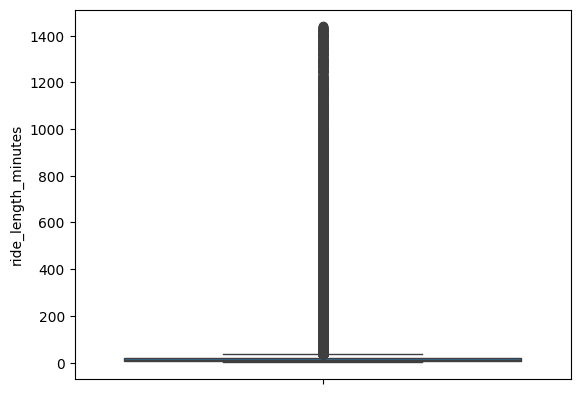

In [15]:
sns.boxplot(bike_trips_df['ride_length_minutes'])

### Outlier Removal and Impact on Ride Duration Analysis

#### Initial box plot analysis revealed extreme outliers in the `ride_length_minutes` column, with some ride times exceeding 1,000 minutes. These skewed the average and made visual interpretation difficult.

#### Using the IQR (Interquartile Range) method, we removed outliers beyond 1.5 times the IQR. 


In [16]:
Q1 = bike_trips_df['ride_length_minutes'].quantile(0.25)
Q3 = bike_trips_df['ride_length_minutes'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#outer_total
outliers = len(bike_trips_df)

# Filter the data
bike_trips_df = bike_trips_df[(bike_trips_df['ride_length_minutes'] >= lower_bound) & (bike_trips_df['ride_length_minutes'] <= upper_bound)]

print(f"Number of outliers: {outliers - len(bike_trips_df)}")
print(f"Total valid rides for analysis: {len(bike_trips_df)}")
print("\nFirst 5 rows with new 'ride_length_minutes' column:")
print(bike_trips_df[['start_time', 'end_time', 'ride_length_minutes']].head())


Number of outliers: 179587
Total valid rides for analysis: 2977715

First 5 rows with new 'ride_length_minutes' column:
           start_time            end_time  ride_length_minutes
0 2019-01-01 00:04:37 2019-01-01 00:11:07                  6.5
1 2019-01-01 00:08:13 2019-01-01 00:15:34                  7.4
2 2019-01-01 00:13:23 2019-01-01 00:27:12                 13.8
3 2019-01-01 00:13:45 2019-01-01 00:43:28                 29.7
4 2019-01-01 00:14:52 2019-01-01 00:20:56                  6.1


<Axes: ylabel='ride_length_minutes'>

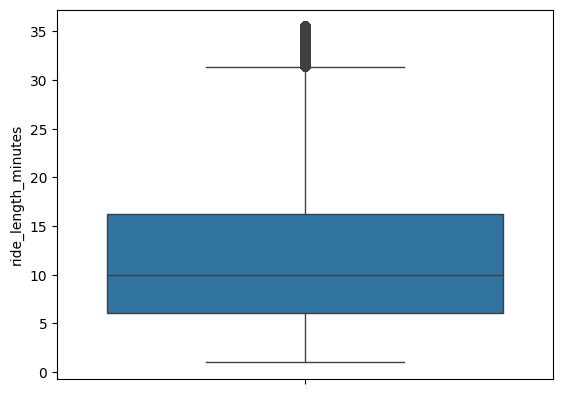

In [17]:
sns.boxplot(bike_trips_df['ride_length_minutes'])

#### The updated box plot shows a more compact and realistic distribution of ride durations.

#### This cleaned data better represents typical rider behavior and allows for more accurate comparisons between casual and member riders.

In [18]:
# Extract time-based features
# 'day_of_week': Full name of the day (e.g., 'Monday')
bike_trips_df['day_of_week'] = bike_trips_df['start_time'].dt.day_name()
# 'month_name': Full name of the month (e.g., 'January')
bike_trips_df['month_name'] = bike_trips_df['start_time'].dt.month_name()
# 'start_hour': Hour of the day (0-23)
bike_trips_df['start_hour'] = bike_trips_df['start_time'].dt.hour
print("\nNew time-based features ('day_of_week', 'month_name', 'start_hour') created.")
print(bike_trips_df[['start_time', 'day_of_week', 'month_name', 'start_hour']].head())


New time-based features ('day_of_week', 'month_name', 'start_hour') created.
           start_time day_of_week month_name  start_hour
0 2019-01-01 00:04:37     Tuesday    January           0
1 2019-01-01 00:08:13     Tuesday    January           0
2 2019-01-01 00:13:23     Tuesday    January           0
3 2019-01-01 00:13:45     Tuesday    January           0
4 2019-01-01 00:14:52     Tuesday    January           0


In [19]:
# ---
# ### 8. Exploratory Data Analysis (EDA)
# ---

print("\n--- Exploratory Data Analysis ---")

print("\nDistribution of User Types:")
print(bike_trips_df['usertype'].value_counts())

print("\nDistribution of Genders:")
print(bike_trips_df['gender'].value_counts())

print("\nAverage Ride Length by User Type (minutes):")
avg_ride_len_by_user = bike_trips_df.groupby('usertype')['ride_length_minutes'].mean().round(2)
print(avg_ride_len_by_user)

print("\nAverage Ride Length by User Type and Day of Week (minutes):")
avg_ride_len_by_user_day = bike_trips_df.groupby(['usertype', 'day_of_week'])['ride_length_minutes'].mean().round(2)
print(avg_ride_len_by_user_day)

print("\nAverage Ride Length by User Type and Month (minutes):")
avg_ride_len_by_user_month = bike_trips_df.groupby(['usertype', 'month_name'])['ride_length_minutes'].mean().round(2)
print(avg_ride_len_by_user_month)

# print("\nAverage Ride Length by User Type and Hour (minutes):")
# avg_ride_len_by_user_hour = bike_trips_df.groupby(['usertype', 'start_hour'])['ride_length_minutes'].mean().round(2)
# print(avg_ride_len_by_user_hour)


--- Exploratory Data Analysis ---

Distribution of User Types:
usertype
Subscriber    2735883
Customer       241832
Name: count, dtype: int64

Distribution of Genders:
gender
Male      2211058
Female     766657
Name: count, dtype: int64

Average Ride Length by User Type (minutes):
usertype
Customer      17.79
Subscriber    11.53
Name: ride_length_minutes, dtype: float64

Average Ride Length by User Type and Day of Week (minutes):
usertype    day_of_week
Customer    Friday         17.36
            Monday         17.46
            Saturday       18.98
            Sunday         18.61
            Thursday       17.02
            Tuesday        16.90
            Wednesday      16.92
Subscriber  Friday         11.27
            Monday         11.40
            Saturday       12.24
            Sunday         12.11
            Thursday       11.38
            Tuesday        11.40
            Wednesday      11.44
Name: ride_length_minutes, dtype: float64

Average Ride Length by User Type and

In [20]:
# ---
# ### 9. Data Visualization
# ---

print("\n--- Data Visualization ---")

def plot_grouped_bar(df, x_col, y_col, group_col, title, x_axis_label, y_axis_label, order=None):
    """
    Generates a grouped bar chart using Plotly.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        x_col (str): Column name for the x-axis.
        y_col (str): Column name for the y-axis (values to plot).
        group_col (str): Column name to group the bars by (e.g., 'usertype', 'gender').
        title (str): Title of the plot.
        x_axis_label (str): Label for the x-axis.
        y_axis_label (str): Label for the y-axis.
        order (list, optional): A list specifying the desired order for the x-axis categories.
                                If None, default sorting is used.
    """
    fig = go.Figure()
    unique_groups = df[group_col].unique()

    # If an order is specified, convert the x_col to a categorical type
    if order is not None:
        df[x_col] = pd.Categorical(df[x_col], categories=order, ordered=True)
        df = df.sort_values(x_col)

    for group in unique_groups:
        group_df = df[df[group_col] == group]
        fig.add_trace(go.Bar(name=group, x=group_df[x_col], y=group_df[y_col]))

    fig.update_layout(
        title=title,
        xaxis_title=x_axis_label,
        yaxis_title=y_axis_label,
        barmode='group',
        xaxis={'categoryorder': 'array', 'categoryarray': order} if order else None # Ensure correct order
    )
    fig.show()

# Define common order for days and months
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Total trips by Day of the Week and User Type
daily_trip_counts = bike_trips_df.groupby(['usertype', 'day_of_week'])['trip_id'].count().reset_index()
plot_grouped_bar(
    daily_trip_counts, 'day_of_week', 'trip_id', 'usertype',
    'Total Trips by Day of the Week and User Type', 'Day of the Week', 'Total Trips',
    order=day_order
)

# Total trips by Month and User Type
monthly_trip_counts = bike_trips_df.groupby(['usertype', 'month_name'])['trip_id'].count().reset_index()
plot_grouped_bar(
    monthly_trip_counts, 'month_name', 'trip_id', 'usertype',
    'Total Trips by Month and User Type', 'Month', 'Total Trips',
    order=month_order
)

# Total trips by Hour of the Day and User Type
hourly_trip_counts = bike_trips_df.groupby(['usertype', 'start_hour'])['trip_id'].count().reset_index()
plot_grouped_bar(
    hourly_trip_counts, 'start_hour', 'trip_id', 'usertype',
    'Total Trips by Hour of the Day and User Type', 'Hour of the Day', 'Total Trips'
)

# Total trips by Day of the Week and Gender
daily_gender_counts = bike_trips_df.groupby(['gender', 'day_of_week'])['trip_id'].count().reset_index()
plot_grouped_bar(
    daily_gender_counts, 'day_of_week', 'trip_id', 'gender',
    'Total Trips by Day of the Week and Gender', 'Day of the Week', 'Total Trips',
    order=day_order
)

# Total trips by Month and Gender
monthly_gender_counts = bike_trips_df.groupby(['gender', 'month_name'])['trip_id'].count().reset_index()
plot_grouped_bar(
    monthly_gender_counts, 'month_name', 'trip_id', 'gender',
    'Total Trips by Month and Gender', 'Month', 'Total Trips',
    order=month_order
)

# Total trips by User Type and Gender
user_gender_counts = bike_trips_df.groupby(['usertype', 'gender'])['trip_id'].count().reset_index()
plot_grouped_bar(
    user_gender_counts, 'usertype', 'trip_id', 'gender',
    'Total Trips by User Type and Gender', 'User Type', 'Total Trips'
)


--- Data Visualization ---


In [22]:
# ---
# ### 10. Station Analysis
# ---

print("\n--- Station Analysis ---")

def get_top_stations(df, group_col, station_col, top_n=5):
    """
    Finds the top N most frequent stations (start or end) grouped by a specified column.

    Args:
        df (pd.DataFrame): The DataFrame containing trip data.
        group_col (str): The column to group by (e.g., 'usertype', 'gender').
        station_col (str): The station column to analyze ('from_station_name' or 'to_station_name').
        top_n (int): The number of top stations to return for each group.

    Returns:
        pd.DataFrame: A DataFrame showing the top N stations for each group.
    """
    station_counts = df.groupby([station_col, group_col])['trip_id'].count().reset_index()
    station_counts_sorted = station_counts.sort_values(by=['trip_id'], ascending=False)
    return station_counts_sorted.groupby(group_col).head(top_n)

print("\nTop 5 Most Frequent Start Stations by User Type:")
top_start_stations_user = get_top_stations(bike_trips_df, 'usertype', 'from_station_name')
print(top_start_stations_user)

print("\nTop 5 Most Frequent End Stations by User Type:")
top_end_stations_user = get_top_stations(bike_trips_df, 'usertype', 'to_station_name')
print(top_end_stations_user)

print("\nTop 5 Most Frequent Start Stations by Gender:")
top_start_stations_gender = get_top_stations(bike_trips_df, 'gender', 'from_station_name')
print(top_start_stations_gender)

print("\nTop 5 Most Frequent End Stations by Gender:")
top_end_stations_gender = get_top_stations(bike_trips_df, 'gender', 'to_station_name')
print(top_end_stations_gender)


--- Station Analysis ---

Top 5 Most Frequent Start Stations by User Type:
                 from_station_name    usertype  trip_id
171            Canal St & Adams St  Subscriber    47802
302        Clinton St & Madison St  Subscriber    42900
312   Clinton St & Washington Blvd  Subscriber    42374
499        Franklin St & Monroe St  Subscriber    29294
316      Columbus Dr & Randolph St  Subscriber    29273
1105       Streeter Dr & Grand Ave    Customer     9885
669      Lake Shore Dr & Monroe St    Customer     5801
671     Lake Shore Dr & North Blvd    Customer     5054
807          Michigan Ave & Oak St    Customer     4059
1109           Theater on the Lake    Customer     3718

Top 5 Most Frequent End Stations by User Type:
                   to_station_name    usertype  trip_id
172            Canal St & Adams St  Subscriber    45379
314   Clinton St & Washington Blvd  Subscriber    45229
304        Clinton St & Madison St  Subscriber    41896
348             Daley Center Plaza  

# important Vizulizations
## Number of ride per day of week

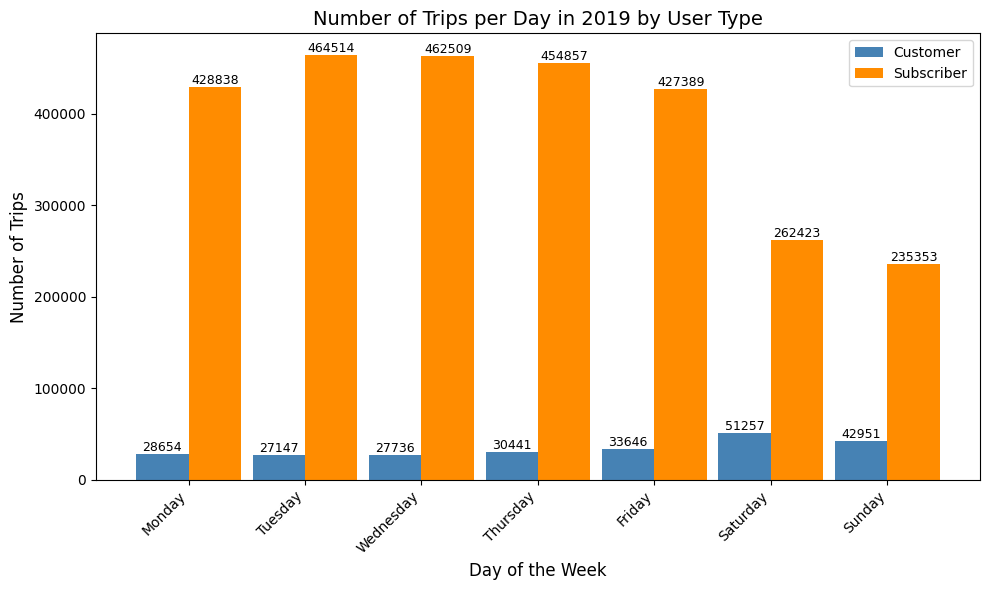


--- Distribution of User Types Visualization ---


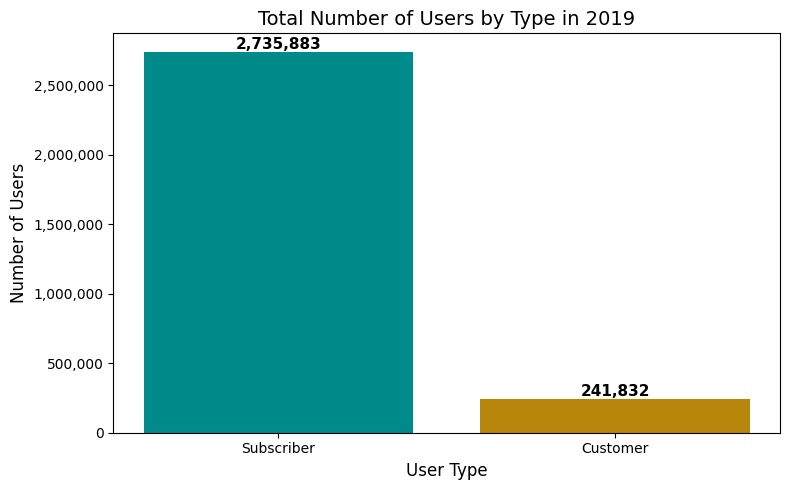

In [23]:
# create daily_trip_counts
daily_trip_counts = bike_trips_df.groupby(['usertype', 'day_of_week'])['trip_id'].count().reset_index()

# Define the order of days for consistent plotting.
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Convert 'day_of_week' to a categorical type with the specified order and sort
daily_trip_counts['day_of_week'] = pd.Categorical(daily_trip_counts['day_of_week'], categories=day_order, ordered=True)
daily_trip_counts = daily_trip_counts.sort_values('day_of_week')
# --- End of Dummy Data Creation ---


# Filter the daily_trip_counts DataFrame for Customer and Subscriber data
customer_daily_rides = daily_trip_counts[daily_trip_counts['usertype'] == 'Customer']
subscriber_daily_rides = daily_trip_counts[daily_trip_counts['usertype'] == 'Subscriber']

# Number of categories (days of the week)
num_categories = len(customer_daily_rides) # Both customer and subscriber will have the same number of days

# Position of bars on the x-axis
x_positions = np.arange(num_categories)

# Width of each bar
bar_width = 0.45

# Create the grouped bar chart using matplotlib
fig, ax = plt.subplots(figsize=(10, 6)) # Set a larger figure size for better readability

# Plot bars for Customers
bar_customer = ax.bar(x_positions - bar_width/2, customer_daily_rides['trip_id'], bar_width, label="Customer", color='steelblue') # Updated color

# Plot bars for Subscribers
bar_subscriber = ax.bar(x_positions + bar_width/2, subscriber_daily_rides['trip_id'], bar_width, label="Subscriber", color='darkorange') # Updated color

# Add legend to distinguish between user types
ax.legend()

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Day of the Week', fontsize=12) # Improved label
ax.set_ylabel('Number of Trips', fontsize=12) # Improved label
ax.set_title('Number of Trips per Day in 2019 by User Type', fontsize=14) # More descriptive title
ax.set_xticks(x_positions)
ax.set_xticklabels(customer_daily_rides['day_of_week'].values, rotation=45, ha='right') # Rotate and align labels

# Function to add labels on top of each bar
def add_bar_labels(bars):
    """
    Adds numerical labels on top of each bar in a bar chart.

    Args:
        bars (matplotlib.container.BarContainer): The bars object returned by ax.bar().
    """
    for bar in bars:
        y_value = bar.get_height()  # Get the height of each bar
        ax.text(bar.get_x() + bar.get_width()/2, y_value, int(y_value), # Display as integer for trip counts
                ha='center', va='bottom', fontsize=9) # Adjust font size for better fit

# Add labels to both sets of bars
add_bar_labels(bar_customer)
add_bar_labels(bar_subscriber)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

# --- New Visualization: Distribution of User Types ---
print("\n--- Distribution of User Types Visualization ---")

# Calculate the counts for each user type
user_type_counts = bike_trips_df['usertype'].value_counts()

# Create the bar chart for user type distribution
fig, ax = plt.subplots(figsize=(8, 5)) # Adjust figure size as needed
bars = ax.bar(user_type_counts.index, user_type_counts.values, color=['darkcyan', 'darkgoldenrod']) # Choose distinct colors

# Format y-axis labels to show full numbers with commas
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Set labels and title for the graph
ax.set_xlabel('User Type', fontsize=12)
ax.set_ylabel('Number of Users', fontsize=12)
ax.set_title('Total Number of Users by Type in 2019', fontsize=14)

# Add labels on top of each bar
def add_value_labels(bars):
    """
    Adds numerical labels on top of each bar in a bar chart, formatted with commas.

    Args:
        bars (matplotlib.container.BarContainer): The bars object returned by ax.bar().
    """
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:,}',
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

add_value_labels(bars)

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

## Percentage of user counts

In [ ]:
# Count user types
user_counts = bike_trips_df['usertype'].value_counts()

# Plotting pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(user_counts.values, labels=user_counts.index, autopct='%1.1f%%', colors=['skyblue', 'orange'])
ax.legend()
ax.set_title('Percentage of User Count')
plt.show()



# Age distributions of our customers

In [ ]:
# Define bins and labels
bins = [18, 25, 30, 35, 40, 45, 50, 55, 60]
labels = ['18–24', '25–29', '30–34', '35–39', '40–44', '45–49', '50–54', '55–60']

# Create age group column
bike_trips_df['age_group'] = pd.cut(bike_trips_df['age'], bins=bins, labels=labels, right=False)

# Count age group frequencies
age_group_counts = bike_trips_df['age_group'].value_counts().sort_index()

# Plotting the chart
fig, ax = plt.subplots(figsize=(8, 7))
bars = age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)

# Customize chart
ax.set_title('Age Distribution of Bike-Share Riders (Ages 18–60)')
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Riders')
ax.set_xticklabels(labels, rotation=45)

# Add labels on top of each bar
for bar in bars.patches:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # Offset above the bar
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Vizulization of number of riders per month

In [ ]:
# Define full month name order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Ensure 'month' values are capitalized correctly
bike_trips_df['months'] = bike_trips_df['month_name'].str.title()

# Set 'month' as ordered categorical type
bike_trips_df['months'] = pd.Categorical(bike_trips_df['months'], categories=month_order, ordered=True)

# Group by full month name and user type
user_by_month_type = bike_trips_df.groupby(['months', 'usertype']).size().unstack().reindex(month_order)

# Plotting grouped bar chart
fig, ax = plt.subplots(figsize=(9, 6))
bar_width = 0.35
x = range(len(user_by_month_type))

# Bar plots for Customer and Subscriber
ax.bar([i - bar_width/2 for i in x], user_by_month_type['Customer'],
       width=bar_width, label='Customer', color='skyblue')
ax.bar([i + bar_width/2 for i in x], user_by_month_type['Subscriber'],
       width=bar_width, label='Subscriber', color='orange')

# Line plot for total
user_by_month_total = user_by_month_type.sum(axis=1)
ax.plot(x, user_by_month_total, marker='o', color='red', linestyle='--', label='Total')

# Axis labels and title
ax.set_xlabel('Months')
ax.set_ylabel('No. of Trips')
ax.set_title('Number of Trips by Month and User Type')
ax.set_xticks(x)
ax.set_xticklabels(user_by_month_type.index, rotation=45)

# Annotate bars
for i in x:
    ax.text(i - bar_width/2, user_by_month_type['Customer'].iloc[i] + 10,
            f"{user_by_month_type['Customer'].iloc[i]:,}", ha='center', fontsize=8)
    ax.text(i + bar_width/2, user_by_month_type['Subscriber'].iloc[i] + 10,
            f"{user_by_month_type['Subscriber'].iloc[i]:,}", ha='center', fontsize=8)

ax.legend()
plt.tight_layout()
plt.show()


### vizulization of no of ride per hour

In [ ]:
# Create 'hour' column from start_time
bike_trips_df['hour'] = bike_trips_df['start_time'].dt.hour

# Group by hour and usertype
rides_by_hour_type = bike_trips_df.groupby(['hour', 'usertype']).size().unstack().fillna(0)

# Plot setup
fig, ax = plt.subplots(figsize=(9, 6))

# Custom line styles and colors
ax.plot(rides_by_hour_type.index, rides_by_hour_type['Customer'], 
        label='Customer', marker='o', color='blue', linestyle='--', linewidth=2)

ax.plot(rides_by_hour_type.index, rides_by_hour_type['Subscriber'], 
        label='Subscriber', marker='s', color='darkorange', linestyle='-', linewidth=2)

# Shaded commute times
ax.axvspan(7, 9, color='lightgrey', alpha=0.3, label='Morning Commute')
ax.axvspan(16, 18, color='lightblue', alpha=0.2, label='Evening Commute')

# Highlight peak hour
peak_hour = rides_by_hour_type.sum(axis=1).idxmax()
ax.axvline(x=peak_hour, color='red', linestyle=':', linewidth=2, label=f'Peak Hour ({peak_hour}:00)')

# Formatting
ax.set_title('Number of Rides by Hour of Day and User Type', fontsize=14)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Rides', fontsize=12)
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h}:00' for h in range(24)], rotation=45)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
bike_trips_df.head()

In [ ]:
# After cleaning the outliers
casual_avg = bike_trips_df[bike_trips_df['usertype'] == 'Customer']['ride_length_minutes'].mean()
member_avg = bike_trips_df[bike_trips_df['usertype'] == 'Subscriber']['ride_length_minutes'].mean()

difference_percent = ((casual_avg - member_avg) / member_avg) * 100

print(f"Casual Avg: {casual_avg:.2f} mins")
print(f"Member Avg: {member_avg:.2f} mins")
print(f"Difference: {difference_percent:.2f}%")
